In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import math
import keras

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.stats import f_oneway

import warnings
warnings.filterwarnings('ignore')

data_path = 'og_data/'

train = pd.read_csv(os.path.join(data_path, 'train.csv'), parse_dates=['date'])
test = pd.read_csv(os.path.join(data_path, 'test.csv'), parse_dates=['date'])

# holidays_events = pd.read_csv(os.path.join(data_path, 'holidays_events.csv'), parse_dates=['date'])
oil = pd.read_csv(os.path.join(data_path, 'oil.csv'), parse_dates=['date'])
stores = pd.read_csv(os.path.join(data_path, 'stores.csv'))
transactions = pd.read_csv(os.path.join(data_path, 'transactions.csv'), parse_dates=['date'])
submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'), index_col='id')

2024-08-06 15:09:34.457397: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 15:09:34.464693: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 15:09:34.514178: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 15:09:34.567654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 15:09:34.621506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

F-statistic: 1506.5585637191425
P-value: 0.0


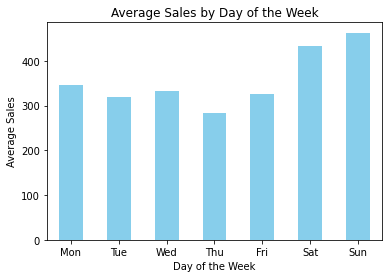

In [2]:

data = pd.read_csv(os.path.join(data_path, 'train.csv'), parse_dates=['date'])

data['dayofweek'] = data['date'].dt.dayofweek

average_sales = data.groupby('dayofweek')['sales'].mean()

average_sales.plot(kind='bar', color='skyblue')
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.xticks(range(0, 7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.savefig('../weekday.png')

grouped = data.groupby('dayofweek')['sales']

sales_data = [group for name, group in grouped]

f_stat, p_value = f_oneway(*sales_data)
print('F-statistic:', f_stat)
print('P-value:', p_value)

In [3]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [4]:
date_min, date_max = train.date.min(), test.date.max()
oil['date'] = pd.to_datetime(oil['date'])
new_df = pd.DataFrame()
new_df['date'] = pd.date_range(date_min, date_max)
new_df = pd.merge(new_df,oil, how="outer", on='date')
new_df['dcoilwtico'] = new_df['dcoilwtico'].interpolate(method = "linear")
oil = new_df

oil_prices = np.asarray(oil['dcoilwtico'])
nans, x= nan_helper(oil_prices)
oil_prices[nans]= np.interp(x(nans), x(~nans), oil_prices[~nans])
oil['dcoilwtico'] = oil_prices

In [5]:
data['date'].dt.dayofyear

0            1
1            1
2            1
3            1
4            1
          ... 
3000883    227
3000884    227
3000885    227
3000886    227
3000887    227
Name: date, Length: 3000888, dtype: int32

In [6]:
def cyclicalcolumn(col):
    return np.sin((2*np.pi*col)/max(col))

In [7]:
train_data = train.copy().drop(['onpromotion'], axis=1)
test_data = test.copy().drop(['onpromotion'], axis=1)

train_data['dayofweek'] = cyclicalcolumn(data['date'].dt.dayofweek)
test_data['dayofweek'] = cyclicalcolumn(data['date'].dt.dayofweek)

train_data['dayofyear'] = cyclicalcolumn(data['date'].dt.dayofyear)
test_data['dayofyear'] = cyclicalcolumn(data['date'].dt.dayofyear)

train_data = train_data.merge(oil, on='date', how='left')
test_data = test_data.merge(oil, on='date', how='left')

# Ordinal Encoding for 'family' column
ordinal_encoder = OrdinalEncoder(dtype=int)
train_data[['family']] = ordinal_encoder.fit_transform(train_data[['family']])
test_data[['family']] = ordinal_encoder.transform(test_data[['family']])

num_days_train = train["date"].nunique()
num_stores_train = train["store_nbr"].nunique()
num_families_train = train["family"].nunique()

num_days_test = test["date"].nunique()
num_stores_test = test["store_nbr"].nunique()
num_families_test = test["family"].nunique()

pivoted_train = train_data.pivot(index=['date','dcoilwtico','dayofweek','dayofyear'], columns=['store_nbr', 'family'], values='sales')

train_samples = int(num_days_train * 0.95)
train_samples_df = pivoted_train[:train_samples]
valid_samples_df = pivoted_train[train_samples:]

print("\nFirst 5 rows of the original train data:")
print(train_samples_df.shape)
print(train_samples_df.head())

minmax_scaler = MinMaxScaler()
minmax_scaler.fit(train_samples_df)
scaled_train_samples = minmax_scaler.transform(train_samples_df)
scaled_validation_samples = minmax_scaler.transform(valid_samples_df)

print("\nFirst 5 rows of the original train data:")
print(scaled_train_samples.shape)
print(scaled_train_samples)


First 5 rows of the original train data:
(1599, 1782)
store_nbr                                        1                         \
family                                          0    1    2       3    4    
date       dcoilwtico dayofweek     dayofyear                               
2013-01-01 93.140000   8.660254e-01 0.017166   0.0  0.0  0.0     0.0  0.0   
2013-01-02 93.140000   8.660254e-01 0.034328   2.0  0.0  2.0  1091.0  0.0   
2013-01-03 92.970000   1.224647e-16 0.051479   3.0  0.0  0.0   919.0  0.0   
2013-01-04 93.120000  -8.660254e-01 0.068615   3.0  0.0  3.0   953.0  0.0   
2013-01-05 93.146667  -8.660254e-01 0.085731   5.0  0.0  3.0  1160.0  0.0   

store_nbr                                                                   \
family                                              5    6       7      8    
date       dcoilwtico dayofweek     dayofyear                                
2013-01-01 93.140000   8.660254e-01 0.017166     0.000  0.0     0.0    0.0   
2013-01-02 93.14

In [8]:
a, count, max_var = 0, 0, 20
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 1e-2, 1e-5 * batch_size, 1e-4
    lr_ramp_ep, lr_sus_ep, lr_decay = 0, 0, 0.75
    line_max, line_min = 1, 1e-2
    
    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'line': 
            m = (lr_min - lr_start)/epochs
            lr = m * epoch + lr_start
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = (epochs - lr_ramp_ep - lr_sus_ep) /(epochs/20), epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            m = (line_min - line_max)/epochs
            control = m * epoch + line_max
            lr = ((lr_start - lr_min) * (1+np.cos(phase)) + lr_min) * control
        elif mode == 'var':
            global a, count, max_var
            m = (lr_min - lr_start)/max_var
            if a < max_var:
                lr = m * (epoch-count) + lr_start
                a += 1
            elif a >= max_var:
                print(epoch-count)
                lr = m * (epoch-count) + lr_start
                count += max_var + 1
                a = 0
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

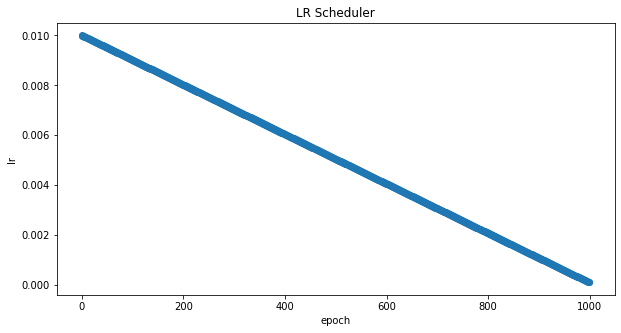

In [9]:
batch_size = 512
lr_mode = 'line'
epochs = 1000 
lr_cb = get_lr_callback(batch_size, mode=lr_mode, epochs=epochs, plot=True)

In [10]:
def split_series(series, n_past, n_future):
    X, y = [], []
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        X.append(series[window_start:past_end, :])
        y.append(series[past_end:future_end, :])
    return np.array(X), np.array(y)

n_future = 16
n_past = scaled_validation_samples.shape[0] - n_future
n_features = num_stores_train * num_families_train

if (n_past - n_future)%2 == 0:
    crop_max = int((n_past - n_future))
else:
    crop_min = int((n_past - n_future)/2)
    crop_max = 2*crop_min + 1

X_train, y_train = split_series(scaled_train_samples, n_past, n_future)
X_val, y_val = split_series(scaled_validation_samples, n_past, n_future)

model = Sequential()
model.add(layers.SeparableConv1D(filters=512, kernel_size=(7), padding='same', input_shape=(n_past, n_features)))
model.add(layers.SeparableConv1D(filters=512, kernel_size=(7), padding='same'))
model.add(layers.SeparableConv1D(filters=512, kernel_size=(7), padding='same'))
model.add(layers.MaxPool1D(strides=1, padding='same'))
model.add(layers.SeparableConv1D(filters=1024, kernel_size=(15), padding='same'))
model.add(layers.SeparableConv1D(filters=1024, kernel_size=(15), padding='same'))
model.add(layers.SeparableConv1D(filters=1024, kernel_size=(15), padding='same'))
model.add(layers.MaxPool1D(strides=1, padding='same'))
model.add(layers.SeparableConv1D(filters=512, kernel_size=(7), padding='same'))
model.add(layers.SeparableConv1D(filters=512, kernel_size=(7), padding='same'))
model.add(layers.SeparableConv1D(filters=512, kernel_size=(7), padding='same'))
model.add(layers.MaxPool1D(strides=1, padding='same'))
model.add(layers.Bidirectional(layers.LSTM(units=256, return_sequences=True)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Bidirectional(layers.LSTM(units=256, return_sequences=True)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Cropping1D(cropping=(0, crop_max)))
model.add(layers.TimeDistributed(layers.Dense(n_features)))

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['msle'])
model.build((None, n_past, n_features))
model.summary()

early_stopping = EarlyStopping(monitor='val_msle', min_delta=1e-4, patience=100, restore_best_weights=True)

model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[lr_cb, early_stopping], 
                          batch_size=batch_size, shuffle=False)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv1d                │ (None, 69, 512)        │       925,370 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_1              │ (None, 69, 512)        │       266,240 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_2              │ (None, 69, 512)        │       266,240 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 69, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_3              │ (None, 69, 1024)       │       532,992 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_4              │ (None, 69, 1024)       │     1,064,960 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_5              │ (None, 69, 1024)       │     1,064,960 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 69, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_6              │ (None, 69, 512)        │       531,968 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_7              │ (None, 69, 512)        │       266,240 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_8              │ (None, 69, 512)        │       266,240 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 69, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 69, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 69, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 69, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 69, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 69, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 69, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d (Cropping1D)         │ (None, 16, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,253,296 (35.30 MB)

 Trainable params: 9,251,248 (35.29 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 35s 10s/step - loss: 0.3601 - msle: 0.0743 - val_loss: 0.2116 - val_msle: 0.0393 - learning_rate: 0.0100
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - loss: 1.0948 - msle: 0.2403 - val_loss: 0.6091 - val_msle: 0.0999 - learning_rate: 0.0100
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - loss: 1.3700 - msle: 0.3730 - val_loss: 0.6297 - val_msle: 0.0920 - learning_rate: 0.0100
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - loss: 0.5253 - msle: 0.1016 - val_loss: 0.5493 - val_msle: 0.0858 - learning_rate: 0.0100
Epoch 5/1000


2024-08-06 15:11:58.716629: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 10s/step - loss: 0.9142 - msle: 0.1749 - val_loss: 0.5451 - val_msle: 0.1059 - learning_rate: 0.0100
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 10s/step - loss: 0.7212 - msle: 0.1538 - val_loss: 0.7718 - val_msle: 0.1767 - learning_rate: 0.0100
Epoch 7/1000


2024-08-06 15:12:56.923575: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 10s/step - loss: 0.6833 - msle: 0.1601 - val_loss: 0.7089 - val_msle: 0.1026 - learning_rate: 0.0099
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 10s/step - loss: 0.4987 - msle: 0.0775 - val_loss: 0.9450 - val_msle: 0.1424 - learning_rate: 0.0099
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 10s/step - loss: 0.4061 - msle: 0.0864 - val_loss: 0.8446 - val_msle: 0.1215 - learning_rate: 0.0099
Epoch 10/1000


2024-08-06 15:14:27.450937: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 10s/step - loss: 0.3288 - msle: 0.0638 - val_loss: 0.7670 - val_msle: 0.1104 - learning_rate: 0.0099
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 10s/step - loss: 0.3172 - msle: 0.0572 - val_loss: 0.4491 - val_msle: 0.0708 - learning_rate: 0.0099
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 10s/step - loss: 0.3116 - msle: 0.0676 - val_loss: 0.4928 - val_msle: 0.1083 - learning_rate: 0.0099
Epoch 13/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 10s/step - loss: 0.2581 - msle: 0.0468 - val_loss: 0.4367 - val_msle: 0.0931 - learning_rate: 0.0099
Epoch 14/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 10s/step - loss: 0.2493 - msle: 0.0487 - val_loss: 0.4171 - val_msle: 0.0885 - learning_rate: 0.0099
Epoch 15/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 10s/step - loss: 0.2174 - msle: 0.0389 - val_loss: 0.4299 - val_msle: 0.0915 - learning_rate: 0.0099
Epoch 16/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 10s/step - loss: 0.1763 - msle: 0.0329 - val_loss: 0.4398 - val_msle: 0.0940 - learning_rate: 0.0099
Epoch 

2024-08-06 15:19:29.957233: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 33s 11s/step - loss: 0.1174 - msle: 0.0180 - val_loss: 0.4278 - val_msle: 0.0886 - learning_rate: 0.0098
Epoch 21/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 10s/step - loss: 0.1147 - msle: 0.0166 - val_loss: 0.4218 - val_msle: 0.0872 - learning_rate: 0.0098
Epoch 22/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 10s/step - loss: 0.1107 - msle: 0.0162 - val_loss: 0.4168 - val_msle: 0.0856 - learning_rate: 0.0098
Epoch 23/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - loss: 0.1069 - msle: 0.0156 - val_loss: 0.4161 - val_msle: 0.0852 - learning_rate: 0.0098
Epoch 24/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - loss: 0.1039 - msle: 0.0147 - val_loss: 0.4103 - val_msle: 0.0834 - learning_rate: 0.0098
Epoch 25/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - loss: 0.1009 - msle: 0.0144 - val_loss: 0.4078 - val_msle: 0.0829 - learning_rate: 0.0098
Epoch 26/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 10s/step - loss: 0.0988 - msle: 0.0138 - val_loss: 0.4029 - val_msle: 0.0816 - learning_rate: 0.0098
Epoch 27/

2024-08-06 15:28:25.964670: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - loss: 0.3176 - msle: 0.0701 - val_loss: 0.2462 - val_msle: 0.0391 - learning_rate: 0.0096
Epoch 40/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - loss: 0.5700 - msle: 0.1186 - val_loss: 0.2610 - val_msle: 0.0449 - learning_rate: 0.0096
Epoch 41/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - loss: 0.3917 - msle: 0.0695 - val_loss: 0.2465 - val_msle: 0.0384 - learning_rate: 0.0096
Epoch 42/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 10s/step - loss: 0.2914 - msle: 0.0473 - val_loss: 0.2992 - val_msle: 0.0467 - learning_rate: 0.0096
Epoch 43/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 10s/step - loss: 0.2349 - msle: 0.0388 - val_loss: 0.2596 - val_msle: 0.0422 - learning_rate: 0.0096
Epoch 44/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 9s/step - loss: 0.2222 - msle: 0.0368 - val_loss: 0.3053 - val_msle: 0.0507 - learning_rate: 0.0096
Epoch 45/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 10s/step - loss: 0.2006 - msle: 0.0321 - val_loss: 0.2708 - val_msle: 0.0435 - learning_rate: 0.0096
Epoch 46/1

In [11]:
x_test_pred = scaled_validation_samples[-n_past:].reshape((1, n_past, n_features))
scaled_y_predict = model.predict(x_test_pred)

y_predict = pd.DataFrame(minmax_scaler.inverse_transform(scaled_y_predict.reshape((n_future, n_features))), columns=valid_samples_df.columns)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step


In [12]:
pivoted_test = test_data.pivot(index=['date','dcoilwtico','dayofweek'], columns=['store_nbr', 'family'], values='id')

for day_ith, day_ith_pred in y_predict.iterrows():
    for n_samples_per_day in range(len(day_ith_pred)):
        sample_id = pivoted_test.iloc[[day_ith], [n_samples_per_day]].values[0][0]
        values = max(0, day_ith_pred.values[n_samples_per_day])
        submission.at[sample_id, 'sales'] = max(0, day_ith_pred.values[n_samples_per_day])

submission.to_csv('submission.csv')
print("\nFirst 5 rows of the data:")
print(submission.head())


First 5 rows of the data:
               sales
id                  
3000888     3.856622
3000889     0.000000
3000890     2.576725
3000891  2080.713379
3000892     0.000000
